The purpose of this Notebook is to determine the main topics of the news articles for Marks & Spencer
and train Random Forest and Logistic Regression to predict next day movement of volatility

In [27]:
# Import libraries
import pandas as pd
import numpy as np
from transformers import pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import re

# Granger's casuality test library
from statsmodels.tsa.stattools import grangercausalitytests

# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


from statsmodels.tsa.api import VAR


# Import VADER for sentiment analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from wordcloud import WordCloud
from gensim.models import LdaModel

import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /Users/luca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/luca/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/luca/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
news_df = pd.read_csv('../Data/Output/obj2_ESG_news_clean.csv')

### Latent Dirichlet Allocation (LDA) fot topics distribution

In [5]:
# Let's extrapolate the pre-processed news articles for M&S only
Marks_Spencer_news_df = news_df[news_df['company'] == 'Marks & Spencer'].reset_index(drop=True)
Marks_Spencer_news_df.head()

,story,date,company,ticker
0,new insight mamps revealing population confide...,2024-07-04,Marks & Spencer,esg
1,working repair alteration specialist sojo uk r...,2024-07-02,Marks & Spencer,esg
2,uk retailer mark spencer tell style currently ...,2024-06-21,Marks & Spencer,esg
3,new insight mamps revealing population confide...,2024-07-04,Marks & Spencer,environment
4,working repair alteration specialist sojo uk r...,2024-07-02,Marks & Spencer,environment


In [6]:
Marks_Spencer_news_df.describe()

,story,date,company,ticker
count,56,56,56,56
unique,46,29,1,4
top,new insight mamps revealing population confide...,2024-07-02,Marks & Spencer,social
freq,4,11,56,45


In [7]:
Marks_Spencer_news_df = Marks_Spencer_news_df[['story','date','company']]
Marks_Spencer_news_df.head()

,story,date,company
0,new insight mamps revealing population confide...,2024-07-04,Marks & Spencer
1,working repair alteration specialist sojo uk r...,2024-07-02,Marks & Spencer
2,uk retailer mark spencer tell style currently ...,2024-06-21,Marks & Spencer
3,new insight mamps revealing population confide...,2024-07-04,Marks & Spencer
4,working repair alteration specialist sojo uk r...,2024-07-02,Marks & Spencer


In [8]:
Marks_Spencer_news_df.describe()

,story,date,company
count,56,56,56
unique,46,29,1
top,new insight mamps revealing population confide...,2024-07-02,Marks & Spencer
freq,4,11,56


### Convert Preprocessed Data into Document-Term Matrix:

In [9]:
# Let's use the CountVectorizer from scikit-learn to transform 
# the preprocessed news articles into a document-term matrix.
# Vectoriser expects a list. Let's convert the content of the column
# 'story' as a list of strings

news_list = Marks_Spencer_news_df['story'].tolist()

In [10]:
s = pd.Series(news_list)
s.describe()

count                                                    56
unique                                                   46
top       new insight mamps revealing population confide...
freq                                                      4
dtype: object

In [11]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(news_list)

In [12]:
dtm

<56x3522 sparse matrix of type '<class 'numpy.int64'>'
	with 9958 stored elements in Compressed Sparse Row format>

### Train the LDA Model

In [13]:
# Let's use gensim to create an LDA model. 
# Specify the number of topics (n_topics), and fit the model to the document-term matrix.

# Tokenize each document in the news_list
tokenized_news_list = [word_tokenize(doc.lower()) for doc in news_list]

In [14]:
# Create a dictionary from the tokenized news
dictionary = corpora.Dictionary(tokenized_news_list)

In [15]:
# Convert the dictionary into a bag of words (BoW) corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_news_list]

In [16]:
# Let's create a function to calculate coherence score in order to 
# determine the best number of topics to train the LDA model 

def compute_coherence_values(dictionary, corpus, tokenized_news_list, start, limit, step):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Train LDA model
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=69,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)
        model_list.append(model)
        
        # Compute coherence score
        coherence_model = CoherenceModel(model=model, 
                                         texts=tokenized_news_list, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values

In [17]:
# Set the range for the number of topics you want to test
start = 2    # Minimum number of topics
limit = 15   # Maximum number of topics (inclusive)
step = 1     # Step size

In [18]:
# Get the optimal model based on coherence score
model_list, coherence_values = compute_coherence_values(dictionary, corpus, tokenized_news_list, start, limit, step)

In [19]:
# Get the best model with the highest coherence score
optimal_num_topics = start + coherence_values.index(max(coherence_values)) * step
best_model = model_list[coherence_values.index(max(coherence_values))]

In [20]:
# Print the best number of topics and the coherence score
print(f"Optimal number of topics: {optimal_num_topics}")
print(f"Coherence score: {max(coherence_values)}")

Optimal number of topics: 7
Coherence score: 0.5620498843298776


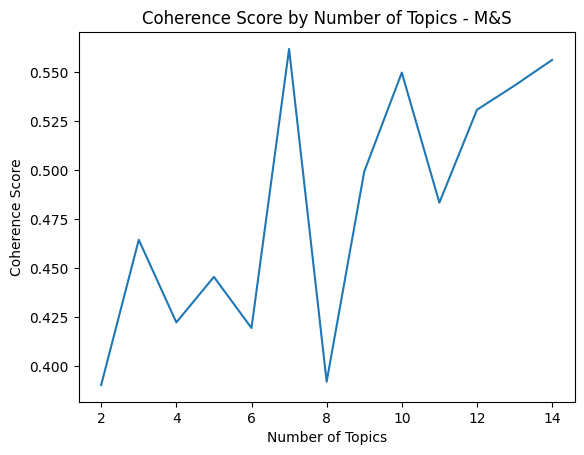

In [24]:
# Let's plot the coherence score as a function of the number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics - M&S")
plt.show()

### Let's verify if the topics are coherent by word clouds

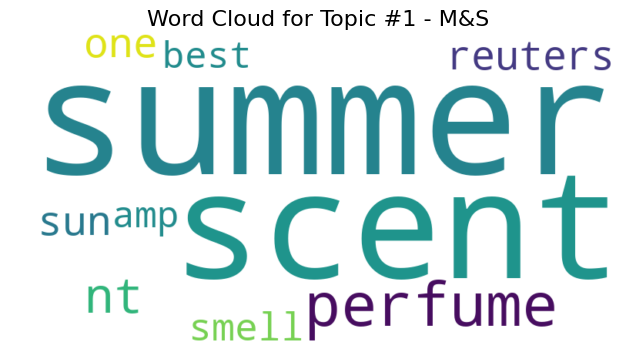

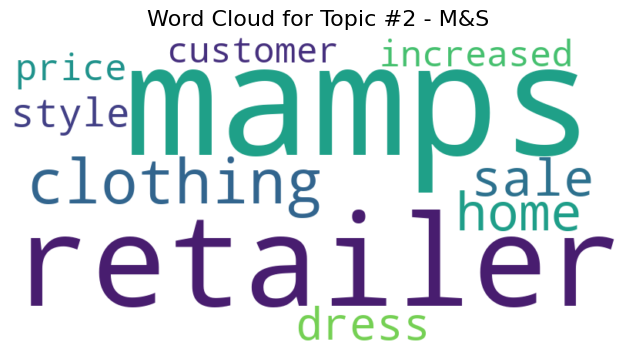

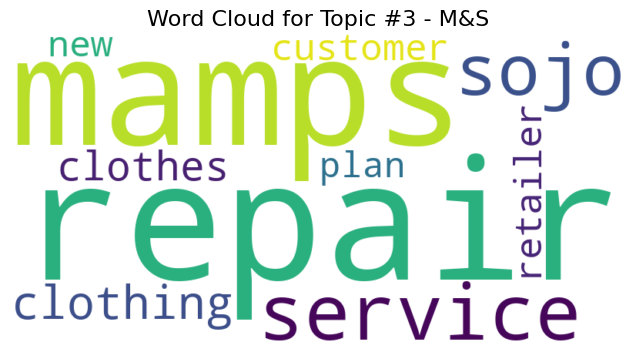

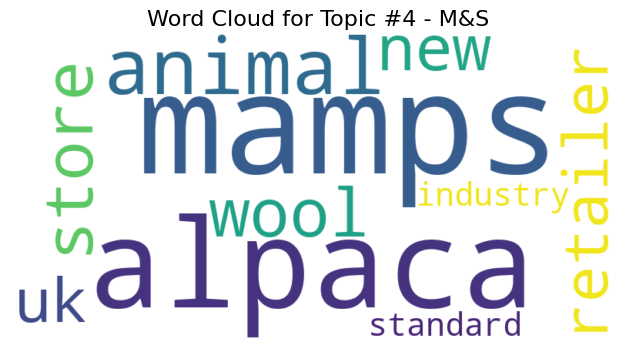

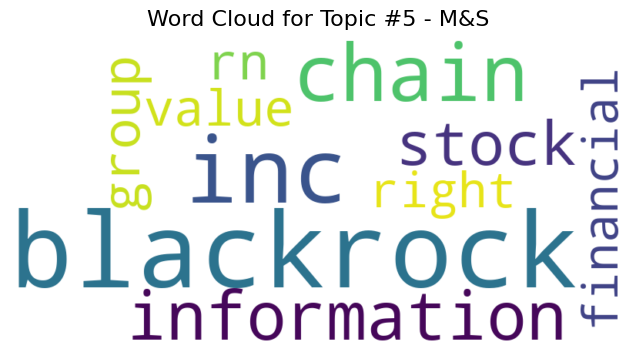

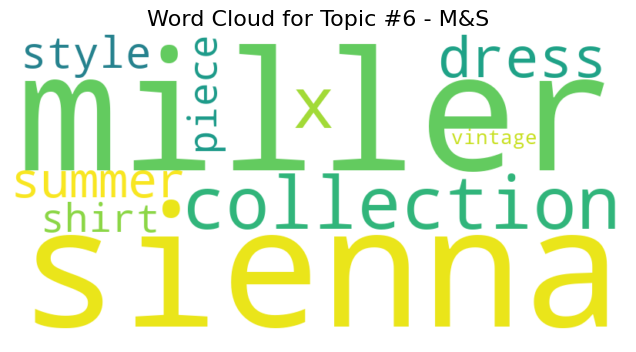

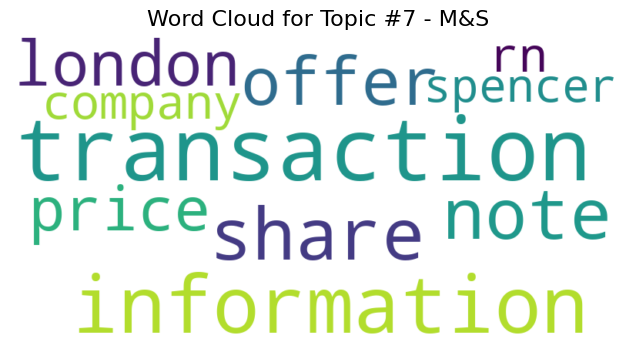

In [25]:
# Let's plot a word cloud for each topic
def plot_word_cloud(lda_model, num_topics, num_words=10):
    for topic_num in range(num_topics):
        # Get the words and their weights for each topic
        topic_words = lda_model.show_topic(topic_num, num_words)
        
        # Convert the topic words to a dictionary where keys are words and values are their importance (weights)
        word_dict = {word: weight for word, weight in topic_words}
        
        # Generate the word cloud for the topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict)
        
        # Plot the word cloud
        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Topic #{topic_num + 1} - M&S", fontsize=16)
        plt.show()

# Get the number of topics from the best model
num_topics = best_model.num_topics

# Plot word clouds for all topics
plot_word_cloud(best_model, num_topics)

In [20]:
# Function to get dominant topic for each document

def get_dominant_topic(lda_model, corpus):
    topic_list = []
    
    for doc_bow in corpus:
        # Get the topic distribution for the document
        topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        
        # Sort the topics by their probabilities and pick the most probable one
        dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0][0]
        
        # Append the dominant topic to the list
        topic_list.append(dominant_topic)
    
    return topic_list

# Step 7: Assign the dominant topic for each document in the dataframe
Marks_Spencer_news_df['topic'] = get_dominant_topic(best_model, corpus)

# Step 8: Output the DataFrame with the new 'topic' column
print(Marks_Spencer_news_df.head())

                                               story        date  \
0  new insight mamps revealing population confide...  2024-07-04   
1  working repair alteration specialist sojo uk r...  2024-07-02   
2  uk retailer mark spencer tell style currently ...  2024-06-21   
3  new insight mamps revealing population confide...  2024-07-04   
4  working repair alteration specialist sojo uk r...  2024-07-02   

           company  topic  
0  Marks & Spencer      2  
1  Marks & Spencer      2  
2  Marks & Spencer      3  
3  Marks & Spencer      2  
4  Marks & Spencer      2  


In [31]:
# Let's aggregate by date and average topic to avoid missing data 

avg_topics_df = Marks_Spencer_news_df.groupby('date')['topic'].mean().reset_index()

# Ensure the 'date' column is in datetime format
avg_topics_df['date'] = pd.to_datetime(avg_topics_df['date'])

# Remove weekends (Saturday and Sunday)
# Use the weekday() method where Monday is 0 and Sunday is 6
avg_topics_df= avg_topics_df[avg_topics_df['date'].dt.weekday < 5]

# Remove the row corresponding to bank holidays
# so the dimension of the df will match the list of stock trading days
avg_topics_df = avg_topics_df[avg_topics_df['date'] != pd.to_datetime('2024-05-06')]
avg_topics_df = avg_topics_df[avg_topics_df['date'] != pd.to_datetime('2024-05-27')]


# Output the filtered DataFrame
print(avg_topics_df.head())

        date  topic
0 2024-05-22    1.0
1 2024-05-29    4.0
2 2024-05-30    6.0
4 2024-06-03    4.0
5 2024-06-06    5.0


### Prepare the Target Variable (Market Returns):

#### Use the pre-existing sentiment scores and corresponding M&S stock returns to create binary labels for market movement (e.g., "UP" or "DOWN") for the following day.

In [32]:
# Let's import merged_df from main

merged_df = pd.read_csv('../Data/Output/obj2_ESGnews_stock_merged.csv')
merged_df

,company,date,Sent_d,daily_return
0,Asda,2024-06-07,0.010250,-0.019094
1,Asda,2024-07-08,0.065600,-0.005153
2,Asda,2024-07-23,-0.045500,0.003829
3,Asda,2024-07-24,0.048000,-0.000708
4,Asda,2024-07-26,-0.049500,-0.003433
...,...,...,...,...
176,Toyota,2024-07-23,0.034458,0.003242
177,Toyota,2024-07-24,0.019665,-0.018041
178,Toyota,2024-07-25,0.025644,-0.009938
179,Toyota,2024-07-26,0.040455,-0.014081


In [35]:
# Let's isolate Marks & Spencer
Marks_Spencer_merged_df = merged_df[merged_df['company'] == 'Marks & Spencer'].reset_index(drop=True)
Marks_Spencer_merged_df.head()

,company,date,Sent_d,daily_return
0,Marks & Spencer,2024-05-22,0.062016,0.050563
1,Marks & Spencer,2024-05-29,0.047012,0.002646
2,Marks & Spencer,2024-05-30,0.042200,0.003626
3,Marks & Spencer,2024-06-03,0.055667,0.013485
4,Marks & Spencer,2024-06-06,0.037000,0.003230


In [36]:
Marks_Spencer_merged_df.describe()

,Sent_d,daily_return
count,25.000000,25.000000
mean,0.051601,0.005479
std,0.015630,0.017834
min,0.025750,-0.028441
25%,0.042200,-0.001733
50%,0.050786,0.005400
75%,0.062016,0.014493
max,0.078286,0.050563


In [37]:
# Let's create 'daily_return_list' as list of daily returns
daily_return_list = Marks_Spencer_merged_df['daily_return'].tolist()


In [38]:
daily_return_list

[0.0505625672815973,
 0.0026455041884241,
 0.0036261783594536,
 0.0134848285764971,
 0.0032299769683326,
 0.0009694620245481,
 -0.0180245200156984,
 -0.0050650116724347,
 0.0167564242298356,
 0.0023106133402798,
 -0.0176289281891309,
 -0.0284411837665582,
 0.0144930073025668,
 0.0068282955648026,
 -0.0255010372700773,
 0.0066098692559997,
 -0.0115084094921675,
 0.0128944111000448,
 -0.0017328023743146,
 0.0053999456224091,
 0.0198995312160191,
 0.0308625939360606,
 0.0074349784875182,
 0.0295118990263204,
 0.017348638334613]

In [39]:
# Assuming 'daily_return_list' is a list of binary 'daily_return'
labels = [1 if daily_return > 0 else 0 for daily_return in daily_return_list]

### Training of the Classifier


#### Let's use Random Forest classifier to predict the next day's market movement based on the LDA topics.

In [55]:
X = avg_topics_df[['topic']][1:] # Use double brackets to convert to a DataFrame
y = labels[1:]

In [56]:
print(len(X))  # Shape of the feature matrix
print(len(y))   # Length of the target vector 


24
24


In [57]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)
 

In [58]:
# Let's train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [59]:
# Predict on test set
y_pred = clf.predict(X_test)


In [60]:
# Evaluate accuracy
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


Accuracy: 0.75


In [61]:
from sklearn.metrics import precision_score
# Evaluate precision
print(f'Precision: {precision_score(y_test, y_pred)}')

Precision: 1.0


In [62]:
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[1 0]
 [2 5]]


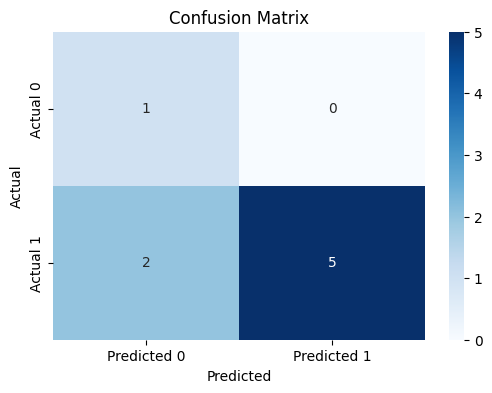

In [63]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Logisitic Regression

In [68]:
X = avg_topics_df[['topic']][1:]  # Ensure X is a DataFrame
y = pd.Series(labels[1:])  # Convert y to a pandas Series

# Let's create lagged target variable for next day prediction
y = y.shift(-1)  # Shift y to make it represent the next day's values


In [69]:
print(len(X))  # Shape of the feature matrix
print(len(y))   # Length of the target vector (should be [n_samples])


24
24


In [70]:
# Let's remove the last row as y would be NaN after shifting
X = X[:-1]
y = y[:-1]

# Let's split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Let's train a Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)


LogisticRegression()

In [71]:
# Let's make predictions
y_pred = log_reg.predict(X_test)

In [72]:
y_pred

array([1., 1., 1., 1., 1., 1., 1.])

In [73]:
# Let's evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7142857142857143


In [74]:
# Let's evaluate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

Precision: 0.7142857142857143


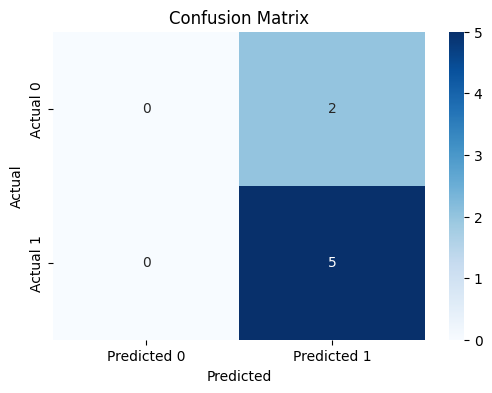

In [75]:
# Let's create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## End of this part